In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

In [31]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook_connected'

def px_plot_bar_means(df, x, y):
    groupedData=df.groupby(x)[y].mean().reset_index(name=y+' mean')
    
    fig = px.bar(groupedData, x=x, y=y+' mean')
    fig.show()

def px_plot_bar_median(df, x, y):
    groupedData=df.groupby(x)[y].median().reset_index(name=y+' median')
    
    fig = px.bar(groupedData, x=x, y=y+' median')
    fig.show()

def px_plot_bar_counts(df, x, y):
    groupedData=df.groupby(x)[y].count().reset_index(name=y+' count')
    
    fig = px.bar(groupedData, x=x, y=y+' count')
    fig.show()

In [32]:
path = '../data/casaData/'
df_listings = pd.read_csv(path + 'trainListings.csv', header=0, usecols=[x for x in range(17)])

/var/folders/fm/m7sbfrtn37dcz2lvxhvj6q0m0000gn/T/ipykernel_11056/196199595.py:2: DtypeWarning:

Columns (0,4,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



In [33]:
# clean id to numeric, and drop old id 
df_listings['id_clean'] = pd.to_numeric(df_listings['id'], errors='coerce')
df_listings = df_listings.dropna(subset='id_clean')
df_listings['id_clean'] = df_listings['id_clean'].astype(int)
df_listings = df_listings.drop('id',axis=1)

#### Source ID - create groups based on number of listings

In [34]:
source_groups = df_listings.groupby('sourceId')['id_clean'].count().reset_index(name='listing_count')

In [35]:
source_groups.head()

,sourceId,listing_count
0,1.0,3520
1,2.0,1851
2,3.0,246
3,4.0,1117
4,5.0,958


In [36]:
# simplify sourceId to source groups based on amount of postings
# assumption that smaller firms have less positings than larger firms 
cut_labels=['v_small', 'small', 'medium', 'large', 'v_large']
source_groups['source_size'] = pd.qcut(
    source_groups['listing_count'],
    q=[0,0.20,0.4,0.6,0.8,1],
    labels=cut_labels)

In [8]:
# def qcut_numToCat5(column, cut_labels=['1','2','3','4','5'], q=list(np.round(np.arange(0,1.1,0.2),1))):
#     new_col = pd.qcut(
#         column,
#         q=q,
#         labels=cut_labels
#     )
#     return new_col

In [37]:
source_groups.head()

,sourceId,listing_count,source_size
0,1.0,3520,v_large
1,2.0,1851,v_large
2,3.0,246,large
3,4.0,1117,v_large
4,5.0,958,v_large


In [38]:
df_listings = pd.merge(left=df_listings, right=source_groups, left_on='sourceId', right_on='sourceId', how='left')
df_listings.drop('listing_count', axis=1, inplace=True)

#### Location ID 
* no context, dropped, all mostly coming from one parentId, when explored

In [39]:
df_listings.drop('locationId', axis=1, inplace=True)

#### Type ID

In [40]:
df_types = pd.read_csv(path + 'types.csv')

In [41]:
df_listings = pd.merge(left=df_listings, right=df_types, left_on='typeId', right_on='id', how='left')

In [42]:
df_listings.drop('id', axis=1, inplace=True)

In [43]:
# drop two listings that were missing 
df_listings[df_listings['typeId'].isna()].iloc[:,0:15]

,sourceId,typeId,price,rooms,bedrooms,bathrooms,totalArea,livingArea,plotArea,terraceArea,title,description,features,latitude,longitude
41743,90.0,NaN,1999000,3.0,NaN,NaN,189221.0,NaN,NaN,NaN,Neubauvorhaben theVIEW an der Hohenfelder Bucht,"im zentralen Stadtteil Hohenfelde, direkt an d...",NaN,53.5634,10.0179
48960,158.0,NaN,695000,NaN,3.0,2.0,200.0,NaN,NaN,NaN,Stonehouse mit garden in the outskirts of Sóll...,NaN,NaN,NaN,NaN


In [44]:
df_listings = df_listings.dropna(subset='typeId', axis=0)

#### Price imputation

In [45]:
# change to float
df_listings['price']= df_listings.price.astype(float)

In [46]:
df_listings.price.describe()

count    7.687300e+04
mean     1.264403e+06
std      2.161149e+06
min      4.500000e+02
25%      3.000000e+05
50%      6.200000e+05
75%      1.450000e+06
max      1.450000e+08
Name: price, dtype: float64

/opt/homebrew/Caskroom/miniforge/base/envs/lhl_env38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



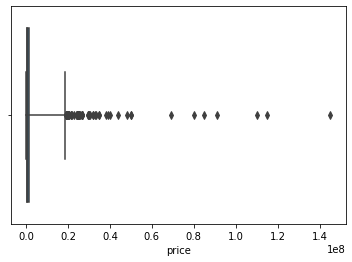

In [47]:
sns.boxplot(df_listings['price'], whis=15)
plt.show()

In [60]:
# keep nan values and values below 60 million - extreme outliers
df_listings = df_listings.drop(df_listings[df_listings['price']>60000000].index)

In [63]:
px_plot_bar_median(df_listings, x='groupName', y='price')

In [64]:
# impute the rest of missing nans with median based on type 
df_listings['price_filled'] = df_listings.groupby(['groupName'])['price'].transform(lambda x: x.fillna(round(x.median(),0)))

In [65]:
# creating price categories 
price_cutLabels = ['v_cheap','cheap','middle','expensive','v_expensive']
df_listings['price_cats'] = pd.qcut(
    df_listings['price_filled'],
    q=[0,0.20,0.4,0.6,0.8,1],
    labels=price_cutLabels)

In [66]:
df_listings['price_log'] = round(np.log(df_listings['price_filled']),3)

In [67]:
print(df_listings.groupby('price_cats')['price_filled'].min())
print(df_listings.groupby('price_cats')['price_filled'].max())

price_cats
v_cheap            450.0
cheap           275185.0
middle          478940.0
expensive       882000.0
v_expensive    1609587.0
Name: price_filled, dtype: float64
price_cats
v_cheap          275000.0
cheap            478835.0
middle           880000.0
expensive       1600000.0
v_expensive    50000000.0
Name: price_filled, dtype: float64


#### Filling rooms

In [68]:
px_plot_bar_median(df_listings, x='groupName', y='bedrooms')

In [69]:
# fill bedrooms and bathrooms with median from grouped price and groupName
df_listings['bedrooms_filled_median'] = df_listings.groupby(['price_cats','groupName'])['bedrooms'].transform(lambda x: x.fillna(round(x.median(),0)))
df_listings['bathrooms_filled_median'] = df_listings.groupby(['price_cats','groupName'])['bathrooms'].transform(lambda x: x.fillna(round(x.median(),0)))

In [70]:
# changing suspected typo of 220
df_listings.at[80165,'bathrooms_filled_median']=2
df_listings.at[80165,'bathrooms']=2

In [71]:
# create bedroom categories 
bedroom_cat_labels = ['1','2','3','4','5','6+']
df_listings['bedroom_cats'] = pd.cut(
    df_listings['bedrooms_filled_median'],
    bins=[0,1,2,3,4,5,5000],
    labels=bedroom_cat_labels)

In [72]:
# create bathroom categories
bath_cat_labels = ['1','2','3','4','5','6+']
df_listings['bathroom_cats'] = pd.cut(
    df_listings['bathrooms_filled_median'],
    bins=[0,1,2,3,4,5,5000],
    labels=bath_cat_labels)

In [73]:
# total area has less missing than living area
# fill nas in totalArea from living Area - because they are highly correlated
# 9800 obs where totalArea=LivingArea 
# totalArea values correspond more with livingArea 
df_listings['area_totalLiving'] = df_listings['totalArea'].fillna(df_listings['livingArea'])

In [74]:
# fill remaining missing areas with group by 
# fill with medians from groups of price and type..
df_listings['area_totalLiving_filled'] = df_listings.groupby(['price_cats','groupName'])['area_totalLiving'].transform(lambda x: x.fillna(round(x.median(),0)))

In [75]:
# create living area categories 
livingArea_labels = ['v_small', 'small','medium','large','v_large']
df_listings['area_totalLiving_cats'] = pd.qcut(
    df_listings['area_totalLiving_filled'],
    q=[0,0.2,0.4,0.6,0.8,1.0],
    labels=livingArea_labels)

#### Plotting area

In [76]:
# fill with medians from groupby of price and totallivingArea_cat
# alot of missing data - may need to be excluded
df_listings['plotArea_filled'] = df_listings.groupby(['price_cats','area_totalLiving_cats'])['plotArea'].transform(lambda x: x.fillna(round(x.median(),0)))

In [77]:
# create plotArea categories 
plotArea_labels = ['v_small', 'small','medium','large','v_large']
df_listings['plotArea_cats'] = pd.qcut(
    df_listings['plotArea_filled'],
    q=[0,0.2,0.4,0.6,0.8,1.0],
    labels=plotArea_labels)

In [78]:
df_listings.head()

,sourceId,typeId,price,rooms,bedrooms,bathrooms,totalArea,livingArea,plotArea,terraceArea,...,price_log,bedrooms_filled_median,bathrooms_filled_median,bedroom_cats,bathroom_cats,area_totalLiving,area_totalLiving_filled,area_totalLiving_cats,plotArea_filled,plotArea_cats
0,1.0,4.0,26500000.0,20.0,10.0,16.0,4000.0,2800.0,820000.0,NaN,...,17.093,10.0,16.0,6+,6+,4000.0,4000.0,v_large,820000.0,v_large
1,9.0,4.0,26500000.0,NaN,10.0,12.0,3000.0,NaN,1200000.0,NaN,...,17.093,10.0,12.0,6+,6+,3000.0,3000.0,v_large,1200000.0,v_large
2,14.0,12.0,26500000.0,NaN,10.0,12.0,3000.0,NaN,NaN,NaN,...,17.093,10.0,12.0,6+,6+,3000.0,3000.0,v_large,2743.0,v_large
3,37.0,10.0,26500000.0,NaN,10.0,12.0,3000.0,NaN,1200000.0,NaN,...,17.093,10.0,12.0,6+,6+,3000.0,3000.0,v_large,1200000.0,v_large
4,85.0,10.0,26500000.0,NaN,10.0,12.0,NaN,NaN,1200000.0,NaN,...,17.093,10.0,12.0,6+,6+,NaN,517.0,v_large,1200000.0,v_large


In [79]:
df_listings.isna().sum()

sourceId                       0
typeId                         0
price                       6176
rooms                      74556
bedrooms                   12842
bathrooms                  14822
totalArea                  26335
livingArea                 52126
plotArea                   38790
terraceArea                65913
title                       4303
description                 2860
features                   40711
latitude                   67118
longitude                  67348
id_clean                       0
source_size                    0
groupName                      0
price_filled                   0
price_cats                     0
price_log                      0
bedrooms_filled_median         0
bathrooms_filled_median        0
bedroom_cats                   0
bathroom_cats                  0
area_totalLiving           13720
area_totalLiving_filled        0
area_totalLiving_cats          0
plotArea_filled                0
plotArea_cats                  0
dtype: int

In [80]:
df_listings.columns

Index(['sourceId', 'typeId', 'price', 'rooms', 'bedrooms', 'bathrooms',
       'totalArea', 'livingArea', 'plotArea', 'terraceArea', 'title',
       'description', 'features', 'latitude', 'longitude', 'id_clean',
       'source_size', 'groupName', 'price_filled', 'price_cats', 'price_log',
       'bedrooms_filled_median', 'bathrooms_filled_median', 'bedroom_cats',
       'bathroom_cats', 'area_totalLiving', 'area_totalLiving_filled',
       'area_totalLiving_cats', 'plotArea_filled', 'plotArea_cats'],
      dtype='object')

In [82]:
df_listings_num = df_listings[['id_clean', 'sourceId','source_size', 'groupName', 
        'price_filled', 'price_cats', 'price_log', 'bedrooms_filled_median', 
        'bathrooms_filled_median', 'bedroom_cats','bathroom_cats', 'area_totalLiving_filled', 
        'area_totalLiving_cats', 'plotArea_filled', 'plotArea_cats']]

In [83]:
df_listings_num.head()

,id_clean,sourceId,source_size,groupName,price_filled,price_cats,price_log,bedrooms_filled_median,bathrooms_filled_median,bedroom_cats,bathroom_cats,area_totalLiving_filled,area_totalLiving_cats,plotArea_filled,plotArea_cats
0,1,1.0,v_large,house,26500000.0,v_expensive,17.093,10.0,16.0,6+,6+,4000.0,v_large,820000.0,v_large
1,2,9.0,v_large,house,26500000.0,v_expensive,17.093,10.0,12.0,6+,6+,3000.0,v_large,1200000.0,v_large
2,3,14.0,v_large,house,26500000.0,v_expensive,17.093,10.0,12.0,6+,6+,3000.0,v_large,2743.0,v_large
3,4,37.0,v_large,house,26500000.0,v_expensive,17.093,10.0,12.0,6+,6+,3000.0,v_large,1200000.0,v_large
4,5,85.0,v_large,house,26500000.0,v_expensive,17.093,10.0,12.0,6+,6+,517.0,v_large,1200000.0,v_large


In [86]:
df_listings_num.shape

(83042, 15)

In [88]:
# df_listings_num.to_csv('trainListings_num.csv')